In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install tensorflow
import tensorflow as tf
print(tf.__version__)

2025-06-21 18:01:06.674772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750528866.876604      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750528866.930660      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
np.random.seed(42)

from matplotlib import style
style.use('fivethirtyeight')

In [3]:
import os
import shutil

# Define paths
source_dirs = [
    "/kaggle/input/dermnet/train",
    "/kaggle/input/dermnet/test"
]

data_dir = "dataset_combined"

# Create destination folder
os.makedirs(data_dir, exist_ok=True)

# Iterate over each source directory (Train and Test)
for source_dir in source_dirs:
    for class_name in os.listdir(source_dir):
        source_class_dir = os.path.join(source_dir, class_name)
        
        # Ensure it's a directory
        if not os.path.isdir(source_class_dir):
            continue

        target_class_dir = os.path.join(data_dir, class_name)
        os.makedirs(target_class_dir, exist_ok=True)

        for file_name in os.listdir(source_class_dir):
            source_file = os.path.join(source_class_dir, file_name)
            target_file = os.path.join(target_class_dir, file_name)

            # Avoid overwriting files with same name
            if os.path.exists(target_file):
                base, ext = os.path.splitext(file_name)
                count = 1
                while os.path.exists(target_file):
                    new_name = f"{base}_{count}{ext}"
                    target_file = os.path.join(target_class_dir, new_name)
                    count += 1

            shutil.copy2(source_file, target_file)

print("✅ Train and Test data merged into:", data_dir)


✅ Train and Test data merged into: dataset_combined


In [4]:
import os

data_dir = "dataset_combined"

# List only folders (classes)
class_names = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Print each class name and total count
print("Classes found:")
for cls in class_names:
    print("-", cls)

print("\nTotal number of classes:", len(class_names))


Classes found:
- Cellulitis Impetigo and other Bacterial Infections
- Systemic Disease
- Poison Ivy Photos and other Contact Dermatitis
- Light Diseases and Disorders of Pigmentation
- Eczema Photos
- Herpes HPV and other STDs Photos
- Scabies Lyme Disease and other Infestations and Bites
- Nail Fungus and other Nail Disease
- Melanoma Skin Cancer Nevi and Moles
- Exanthems and Drug Eruptions
- Psoriasis pictures Lichen Planus and related diseases
- Atopic Dermatitis Photos
- Lupus and other Connective Tissue diseases
- Vascular Tumors
- Bullous Disease Photos
- Acne and Rosacea Photos
- Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions
- Warts Molluscum and other Viral Infections
- Hair Loss Photos Alopecia and other Hair Diseases
- Seborrheic Keratoses and other Benign Tumors
- Vasculitis Photos
- Tinea Ringworm Candidiasis and other Fungal Infections
- Urticaria Hives

Total number of classes: 23


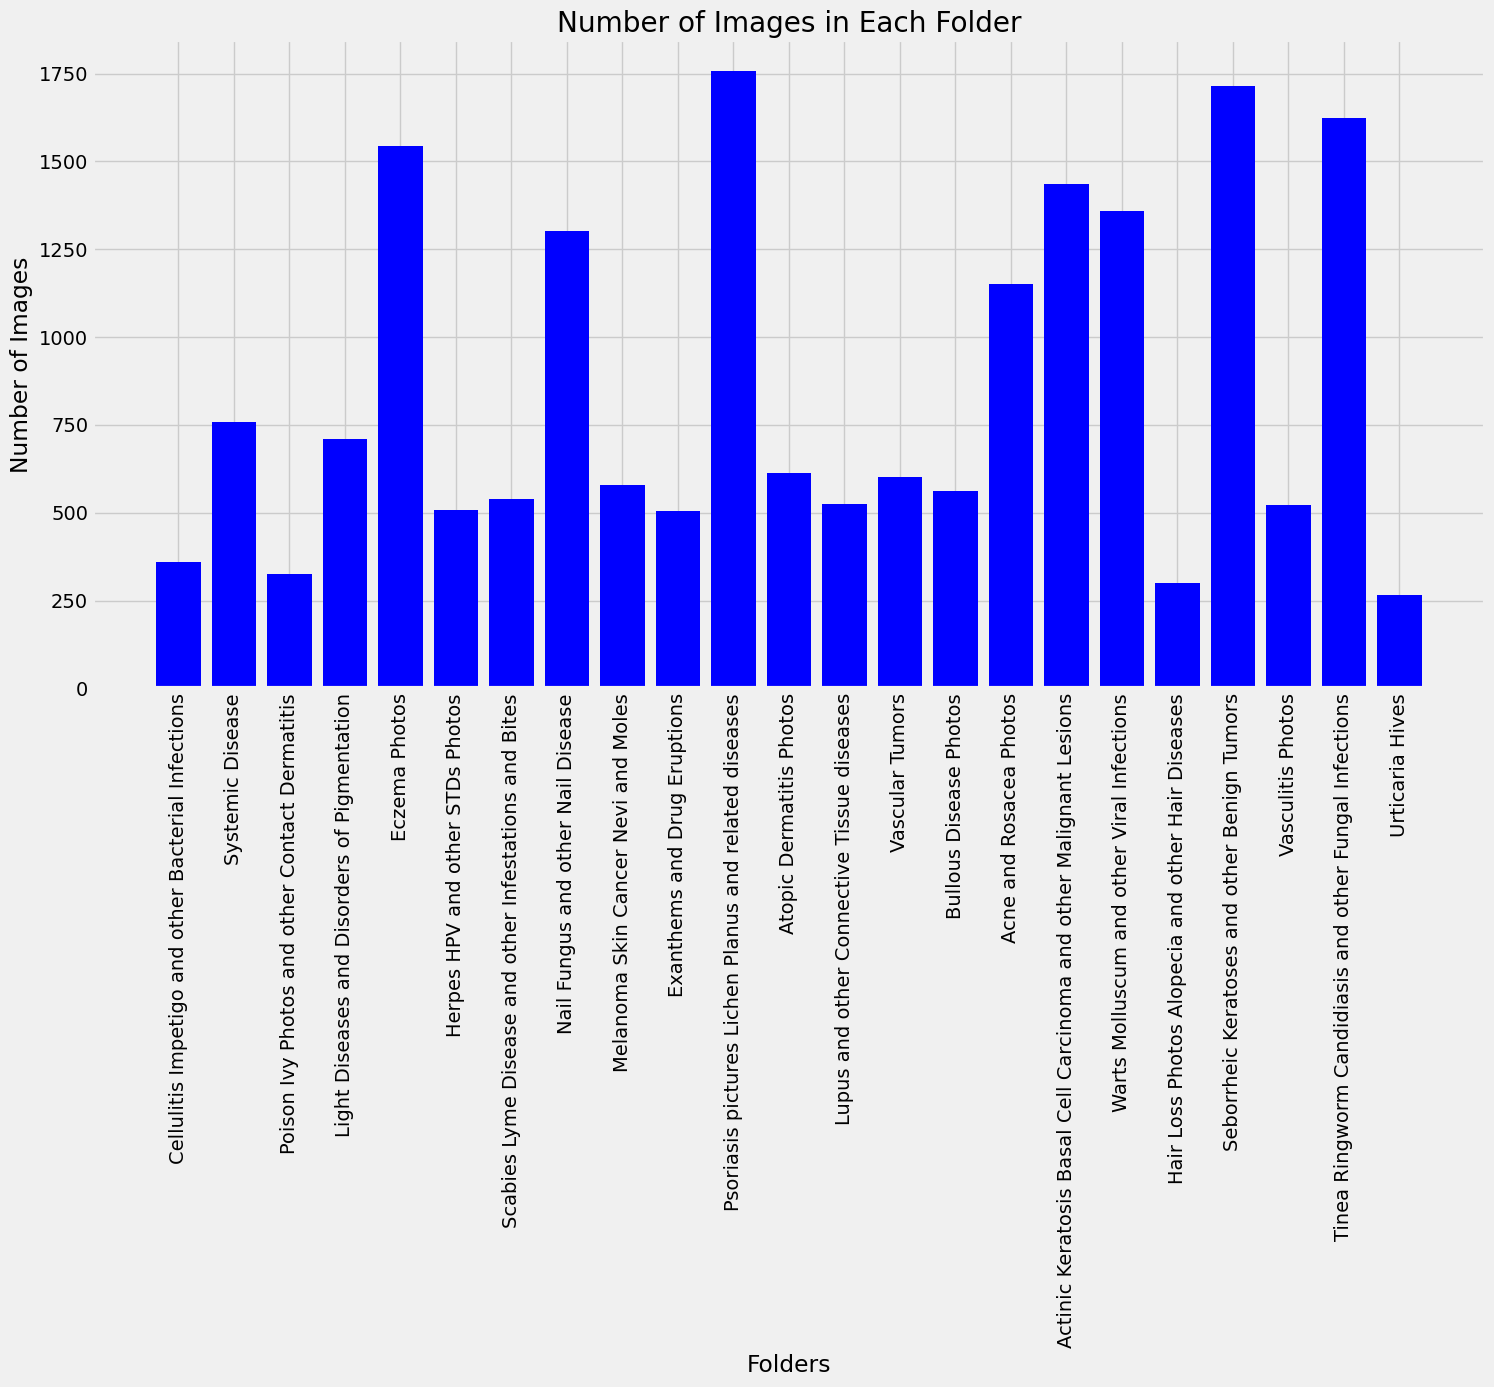

Folder: Cellulitis Impetigo and other Bacterial Infections, Number of Images: 361
Folder: Systemic Disease, Number of Images: 758
Folder: Poison Ivy Photos and other Contact Dermatitis, Number of Images: 325
Folder: Light Diseases and Disorders of Pigmentation, Number of Images: 711
Folder: Eczema Photos, Number of Images: 1544
Folder: Herpes HPV and other STDs Photos, Number of Images: 507
Folder: Scabies Lyme Disease and other Infestations and Bites, Number of Images: 539
Folder: Nail Fungus and other Nail Disease, Number of Images: 1301
Folder: Melanoma Skin Cancer Nevi and Moles, Number of Images: 579
Folder: Exanthems and Drug Eruptions, Number of Images: 505
Folder: Psoriasis pictures Lichen Planus and related diseases, Number of Images: 1757
Folder: Atopic Dermatitis Photos, Number of Images: 612
Folder: Lupus and other Connective Tissue diseases, Number of Images: 525
Folder: Vascular Tumors, Number of Images: 603
Folder: Bullous Disease Photos, Number of Images: 561
Folder: Ac

In [7]:
import os
import matplotlib.pyplot as plt

def count_images_in_folders(folder_path):
    folder_counts = {}
    for folder in os.listdir(folder_path):
        folder_full_path = os.path.join(folder_path, folder)
        if os.path.isdir(folder_full_path):
            # Count the number of files (images) in each subfolder
            num_images = len([file for file in os.listdir(folder_full_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
            folder_counts[folder] = num_images
    return folder_counts

# Count number of images
folder_counts = count_images_in_folders(data_dir)

# Plotting
plt.figure(figsize=(16, 8))
folders = list(folder_counts.keys())
counts = list(folder_counts.values())

plt.bar(folders, counts, color='blue')
plt.xlabel('Folders')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Folder')
plt.xticks(rotation='vertical')
plt.show()

# Print the number of images with folder name
for folder, count in folder_counts.items():
    print(f"Folder: {folder}, Number of Images: {count}")

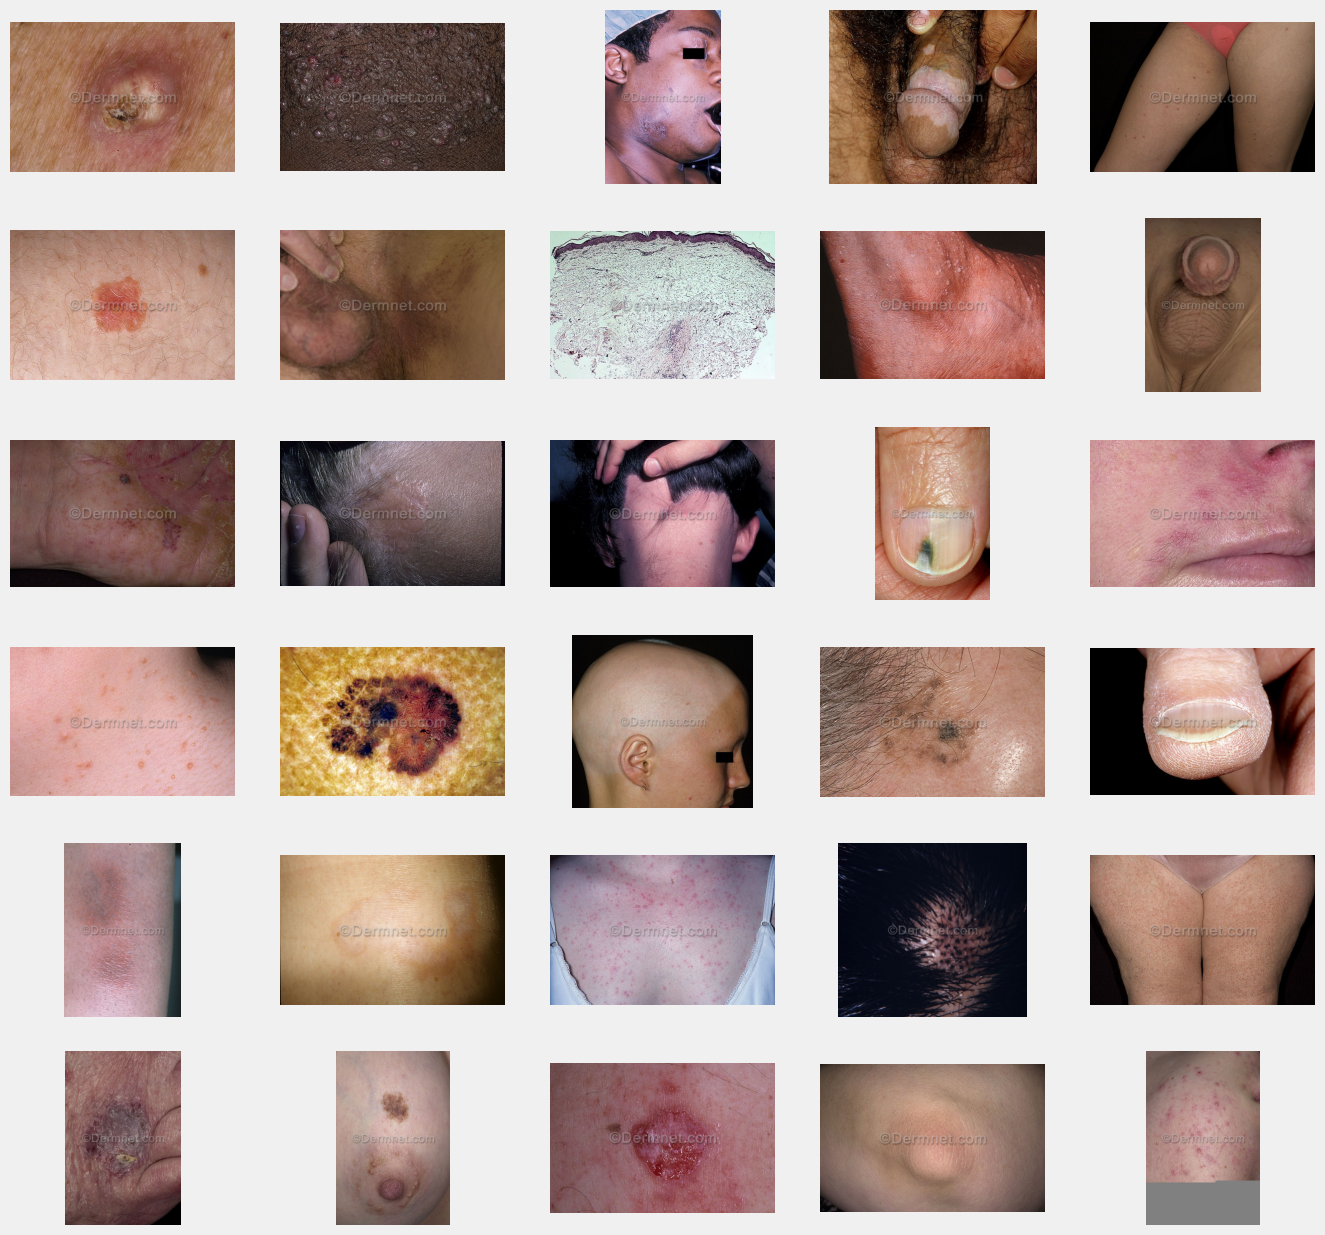

In [8]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Function to get a list of file paths in each subfolder
def get_image_paths_in_folders(folder_path):
    image_paths = []
    for folder in os.listdir(folder_path):
        folder_full_path = os.path.join(folder_path, folder)
        if os.path.isdir(folder_full_path):
            # Get a list of file paths for images in each subfolder
            image_paths.extend([os.path.join(folder_full_path, file) for file in os.listdir(folder_full_path)
                                if file.lower().endswith(('.jpg', '.jpeg', '.png'))])
    return image_paths

# Get a list of image paths
image_paths = get_image_paths_in_folders(data_dir)

# Randomly 30 images
selected_images = random.sample(image_paths, 30)

# Plotting
plt.figure(figsize=(15, 15))
for i, image_path in enumerate(selected_images, 1):
    plt.subplot(6, 5, i)
    plt.imshow(Image.open(image_path))
    plt.axis('off')

plt.show()


In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to read, resize, and collect images in a folder
def read_and_resize_images(folder_path, img_width, img_height):
    data = []
    labels = []

    for folder in os.listdir(folder_path):
        folder_full_path = os.path.join(folder_path, folder)

        if os.path.isdir(folder_full_path):
            # Count the number of files (images) in each subfolder
            num_images = len([file for file in os.listdir(folder_full_path) if file.lower().endswith(('.jpg', '.jpeg', '.png'))])

            # Skip folders without images
            if num_images == 0:
                continue

            # Get the class label for the folder
            label = folder

            # Iterate through each image in the folder
            for filename in os.listdir(folder_full_path):
                img_path = os.path.join(folder_full_path, filename)

                # Read and resize the image
                img = cv2.imread(img_path)

                img = cv2.resize(img, (img_width, img_height))
                data.append(img)
                labels.append(label)

    return np.array(data), np.array(labels)

# Resizing the image
IMG_HEIGHT = 96
IMG_WIDTH = 96

# Read and resize images
image_data, labels = read_and_resize_images(data_dir, IMG_WIDTH, IMG_HEIGHT)

print("Image Data shape:", image_data.shape)
print("Labels shape:", labels.shape)


Image Data shape: (19559, 96, 96, 3)
Labels shape: (19559,)


In [10]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
labels = labels[shuffle_indexes]

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(image_data, labels, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

# Normalizing the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_val.shape:", y_val.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (15647, 96, 96, 3)
X_val.shape: (1956, 96, 96, 3)
X_test.shape: (1956, 96, 96, 3)
y_train.shape: (15647,)
y_val.shape: (1956,)
y_test.shape: (1956,)


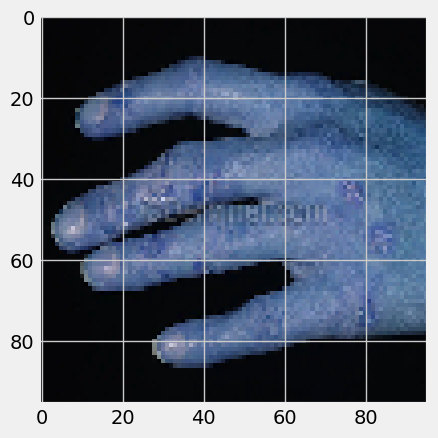

In [12]:
plt.imshow(X_train [0])

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert lbls string to numerical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding
y_train_onehot = to_categorical(y_train_encoded)
y_val_onehot = to_categorical(y_val_encoded)
y_test_onehot = to_categorical(y_test_encoded)

print("y_train_onehot.shape:", y_train_onehot.shape)
print("y_val_onehot.shape:", y_val_onehot.shape)
print("y_test_onehot.shape:", y_test_onehot.shape)

y_train_onehot.shape: (15647, 23)
y_val_onehot.shape: (1956, 23)
y_test_onehot.shape: (1956, 23)


In [14]:
print(y_val_onehot [0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


# Model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# ← here: 23 units for 23 classes
model.add(Dense(23, activation='softmax'))

In [17]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 20, 20, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 23)                  │             759 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,679 (1.75 MB)

 Trainable params: 458,679 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
lr = 0.001
epochs = 100

opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [20]:
# Train the model
history = model.fit(X_train, y_train_onehot, batch_size=32, epochs=epochs, validation_data=(X_val, y_val_onehot))

Epoch 1/100


I0000 00:00:1750529271.809071     117 service.cc:148] XLA service 0x10a86e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750529271.809792     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750529271.809843     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750529272.182245     117 cuda_dnn.cc:529] Loaded cuDNN version 90300


 19/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0532 - loss: 3.1242  

I0000 00:00:1750529275.356565     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


489/489 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.1056 - loss: 2.9964 - val_accuracy: 0.1478 - val_loss: 2.8725
Epoch 2/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1597 - loss: 2.8252 - val_accuracy: 0.1748 - val_loss: 2.7993
Epoch 3/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1880 - loss: 2.7366 - val_accuracy: 0.2157 - val_loss: 2.6879
Epoch 4/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2078 - loss: 2.6644 - val_accuracy: 0.2147 - val_loss: 2.6168
Epoch 5/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2312 - loss: 2.5878 - val_accuracy: 0.2229 - val_loss: 2.6044
Epoch 6/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2456 - loss: 2.5258 - val_accuracy: 0.2336 - val_loss: 2.5672
Epoch 7/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2656 - loss: 2.4625 - val_accuracy: 0.2311 - val_loss: 2.5512
Epoch 8/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.2844 - loss: 2.3964 - val_accuracy: 0.26

In [21]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

# Extract final training and validation accuracy from history
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Print all three
print(f"✅ Final Training Accuracy:   {train_accuracy * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"✅ Final Test Accuracy:       {test_accuracy * 100:.2f}%")

✅ Final Training Accuracy:   82.95%
✅ Final Validation Accuracy: 27.76%
✅ Final Test Accuracy:       26.07%


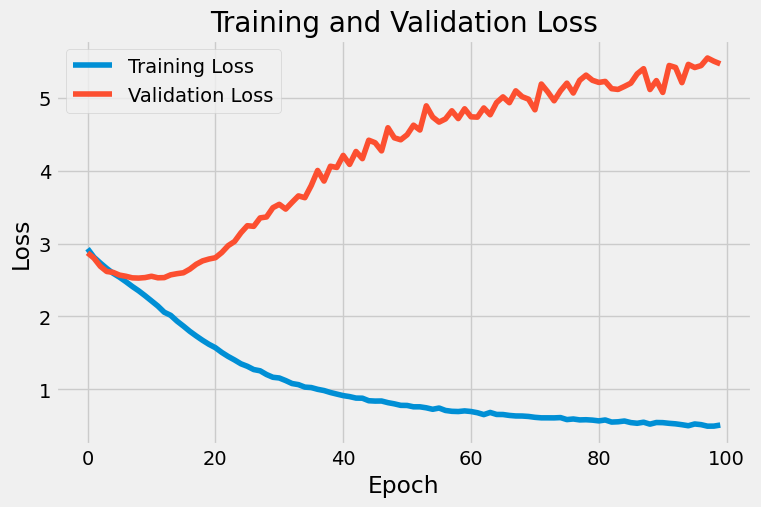

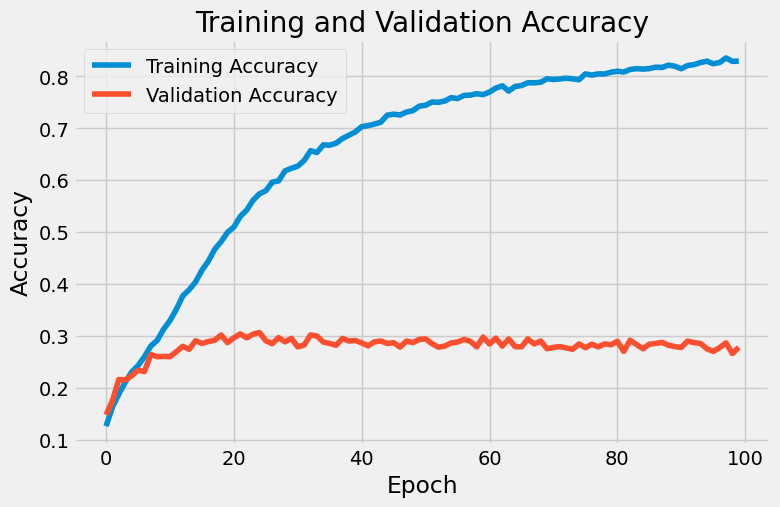

In [22]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

# Using data augmentation

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential()

model.add(Conv2D(32, (3, 3), strides=1, activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), strides=1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# ← here: 23 units for 23 classes
model.add(Dense(23, activation='softmax'))

# data augmentation

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,      # Degree range for random rotations
    width_shift_range=0.2,  # Fraction of total width for random horizontal shifts
    height_shift_range=0.2, # Fraction of total height for random vertical shifts
    shear_range=0.2,        # Shear angle in counter-clockwise direction
    zoom_range=0.2,         # Random zoom range
    horizontal_flip=True,   # Randomly flip inputs horizontally
    vertical_flip=True      # Randomly flip inputs vertically
)

# Fit the generator on the training data
datagen.fit(X_train)

# Create augmented training, validation, and test sets
augmented_train = datagen.flow(X_train, y_train_onehot, batch_size=32)
augmented_val = datagen.flow(X_val, y_val_onehot, batch_size=32)
augmented_test = datagen.flow(X_test, y_test_onehot, batch_size=32)

In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 20, 20, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 23)                  │             759 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 458,679 (1.75 MB)

 Trainable params: 458,679 (1.75 MB)

 Non-trainable params: 0 (0.00 B)

# Model Compaile

In [26]:
# Compile the model
lr = 0.001
epochs = 100
opt = Adam(learning_rate=lr, decay=lr / (epochs * 0.5))
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [27]:
# Train the model with augmented data
history = model.fit(augmented_train, epochs=epochs, validation_data=augmented_val)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


489/489 ━━━━━━━━━━━━━━━━━━━━ 46s 85ms/step - accuracy: 0.0930 - loss: 3.0090 - val_accuracy: 0.1350 - val_loss: 2.9078
Epoch 2/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.1347 - loss: 2.8895 - val_accuracy: 0.1518 - val_loss: 2.8380
Epoch 3/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.1483 - loss: 2.8506 - val_accuracy: 0.1503 - val_loss: 2.8224
Epoch 4/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.1595 - loss: 2.8086 - val_accuracy: 0.1764 - val_loss: 2.7869
Epoch 5/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.1674 - loss: 2.7862 - val_accuracy: 0.1794 - val_loss: 2.7506
Epoch 6/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 39s 79ms/step - accuracy: 0.1761 - loss: 2.7695 - val_accuracy: 0.1881 - val_loss: 2.7384
Epoch 7/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 38s 78ms/step - accuracy: 0.1828 - loss: 2.7509 - val_accuracy: 0.1943 - val_loss: 2.7160
Epoch 8/100
489/489 ━━━━━━━━━━━━━━━━━━━━ 37s 76ms/step - accuracy: 0.1894 - loss: 2.7378 - val_

In [28]:

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)

# Extract final training and validation accuracy from history
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Print all three
print(f"✅ Final Training Accuracy:   {train_accuracy * 100:.2f}%")
print(f"✅ Final Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"✅ Final Test Accuracy:       {test_accuracy * 100:.2f}%")

✅ Final Training Accuracy:   30.53%
✅ Final Validation Accuracy: 30.88%
✅ Final Test Accuracy:       27.86%


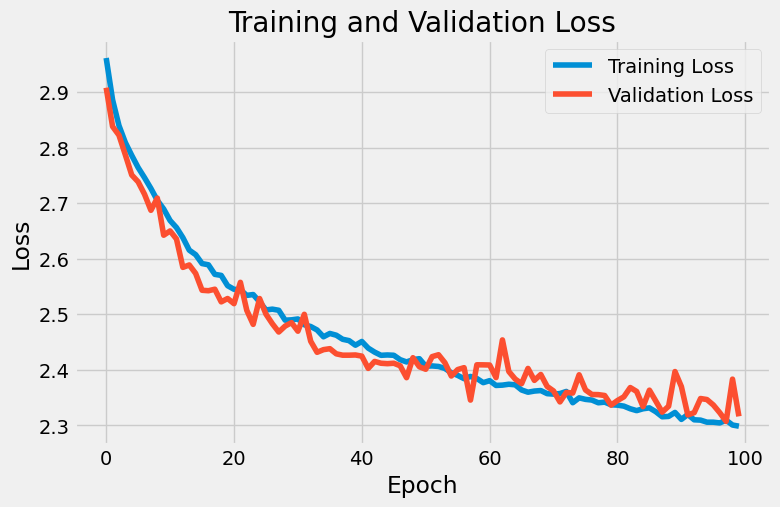

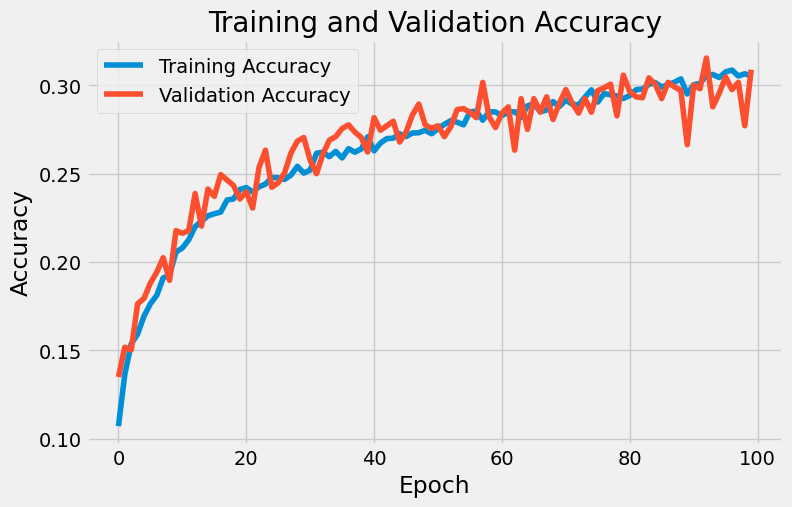

In [29]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(8, 5))

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()
